<a href="https://colab.research.google.com/github/neelkothari6191/COVID-19-Detection-through-CT-Scans/blob/main/COVID_19_Detection_through_CT_Scans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DL Mini Project to accurately detect COVID 19.

Team:

> Mohammed Raza Syed (60004200019)
>
> Neel Kothari (60004200034)
>

In [ ]:
!pip install scikit-image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import pathlib

import PIL
from imageio import imread
from skimage.transform import resize

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers


import os
import datetime
import time
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from tensorflow.keras import layers

In [ ]:
data_dir_covid = pathlib.Path('/content/drive/MyDrive/Dataset/sarscov2-ctscan-dataset/COVID')
data_dir_non_covid = pathlib.Path('/content/drive/MyDrive/Dataset/sarscov2-ctscan-dataset/non-COVID')

In [ ]:
img_count_covid = len(list(data_dir_covid.glob('*.png')))
img_count_non_covid = len(list(data_dir_non_covid.glob('*.png')))

print("Image count in Covid set: ",img_count_covid)
print("Image count in Non Covid set: ",img_count_non_covid)

Image count in Covid set:  1252
Image count in Non Covid set:  1229


In [ ]:
!pip install split-folders

In [ ]:
import splitfolders
splitfolders.ratio("/content/drive/MyDrive/Dataset/sarscov2-ctscan-dataset", output="/content/drive/MyDrive/Dataset/sarscov2-ctscan-dataset/working/dataset",
    seed=1337, ratio=(.7, .2, .1), group_prefix=None, move=False)

Copying files: 2481 files [13:27,  3.07 files/s]


In [ ]:
data_dir_train = pathlib.Path('/content/drive/MyDrive/Dataset/sarscov2-ctscan-dataset/working/dataset/train')
data_dir_val = pathlib.Path('/content/drive/MyDrive/Dataset/sarscov2-ctscan-dataset/working/dataset/val')
data_dir_test = pathlib.Path('/content/drive/MyDrive/Dataset/sarscov2-ctscan-dataset/working/dataset/test')

In [ ]:
img_count_train = len(list(data_dir_train.glob('*/*.png')))
img_count_val = len(list(data_dir_val.glob('*/*.png')))
img_count_test = len(list(data_dir_test.glob('*/*.png')))

print("Image count in Train set: ",img_count_train)
print("Image count in Val set: ",img_count_val)
print("Image count in Test set: ",img_count_test)



Image count in Train set:  1736
Image count in Val set:  495
Image count in Test set:  250


## EDA

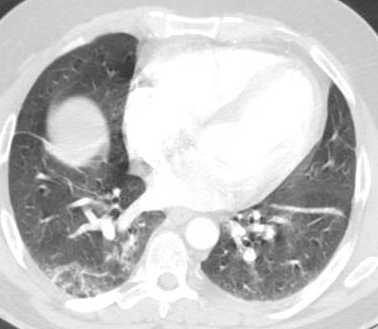

In [ ]:
covid = list(data_dir_train.glob('COVID/*'))
PIL.Image.open(str(covid[0]))

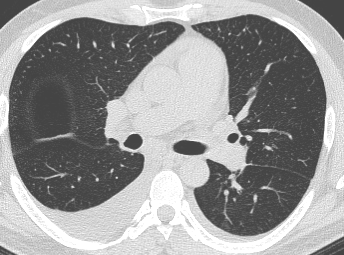

In [ ]:
PIL.Image.open(str(covid[2]))

Image size:  (310, 244)


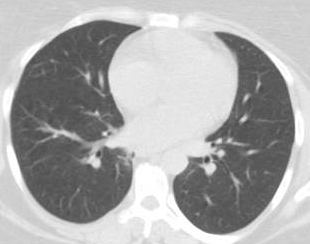

In [ ]:
non_covid = list(data_dir_train.glob('non-COVID/*'))
img1 = PIL.Image.open(str(non_covid[0]))
print("Image size: " ,img1.size)
img1

Image size:  (449, 323)


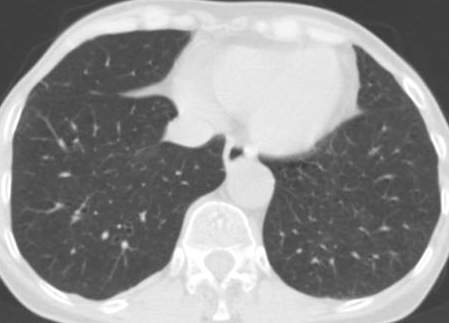

In [ ]:
img2 = PIL.Image.open(str(non_covid[-1]))
print("Image size: " ,img2.size)
img2

# Data Generator

In [ ]:
def data_generator(data_source,img_height, img_width, btc_size):
    return tf.keras.utils.image_dataset_from_directory(
        data_source,
        validation_split=None,
        subset=None,
        seed=123,
        color_mode='grayscale',
        image_size=(img_height, img_width),
        batch_size=btc_size,
        crop_to_aspect_ratio=True,
        shuffle=True
    )

In [ ]:
batch_size=32
img_height = 256
img_width = 256
num_epochs = 1

**Create dataset:**

In [ ]:
train_ds = data_generator(data_dir_train,img_height, img_width, batch_size)
val_ds = data_generator(data_dir_val,img_height, img_width, batch_size)

Found 1736 files belonging to 3 classes.
Found 495 files belonging to 3 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['COVID', 'non-COVID', 'working']


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
def print_param():
    print("*** Params used in Model Training ****")
    print("Batch Size: ", batch_size)
    print("Epoch Size: ", num_epochs)
    print("Image size: {} {}".format(img_height, img_width))
    print("***********************")


In [ ]:
def train_model(model_init, model):
    train_ds = data_generator(data_dir_train,img_height, img_width, batch_size)
    val_ds = data_generator(data_dir_val,img_height, img_width, batch_size)
    curr_dt_time = datetime.datetime.now()
    model_name = model_init + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{accuracy:.5f}-{val_loss:.5f}-{val_accuracy:.5f}.h5'
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

    Earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=7,verbose=1)

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, cooldown=4, verbose=1,mode='auto',epsilon=0.0001)

    callbacks_list = [checkpoint, LR, Earlystop]

    print_param()


    start = time.time()
    history = model.fit(train_ds, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_ds,
                    class_weight=None, workers=1, initial_epoch=0)
    end = time.time()
    print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")
    return history

In [ ]:
def plot_metrics(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(num_epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

## Model #1

In [ ]:
num_classes = len(class_names)

In [ ]:
base_model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
base_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

In [ ]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1

In [ ]:
batch_size=32
img_height = 256
img_width = 256
num_epochs = 50

In [ ]:
history_base_model = train_model("base_model",base_model)

Found 1736 files belonging to 3 classes.
Found 495 files belonging to 3 classes.


*** Params used in Model Training ****
Batch Size:  32
Epoch Size:  50
Image size: 256 256
***********************
Epoch 1/50
55/55 [==============================] - ETA: 0s - loss: 0.6759 - accuracy: 0.6313
Epoch 1: val_loss improved from inf to 0.84396, saving model to base_model_2023-11-3017_25_04.420588/model-00001-0.67592-0.63134-0.84396-0.53939.h5
55/55 [==============================] - 30s 247ms/step - loss: 0.6759 - accuracy: 0.6313 - val_loss: 0.8440 - val_accuracy: 0.5394 - lr: 0.0010
Epoch 2/50
53/55 [===========================>..] - ETA: 0s - loss: 0.4958 - accuracy: 0.7642
Epoch 2: val_loss improved from 0.84396 to 0.42421, saving model to base_model_2023-11-3017_25_04.420588/model-00002-0.49351-0.76498-0.42421-0.80000.h5
55/55 [==============================] - 10s 161ms/step - loss: 0.4935 - accuracy: 0.7650 - val_loss: 0.4242 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 3/50
53/55 [===========================>..] - ETA: 0s - loss: 0.3596 - accuracy: 0.8390
Epoch 3: val_

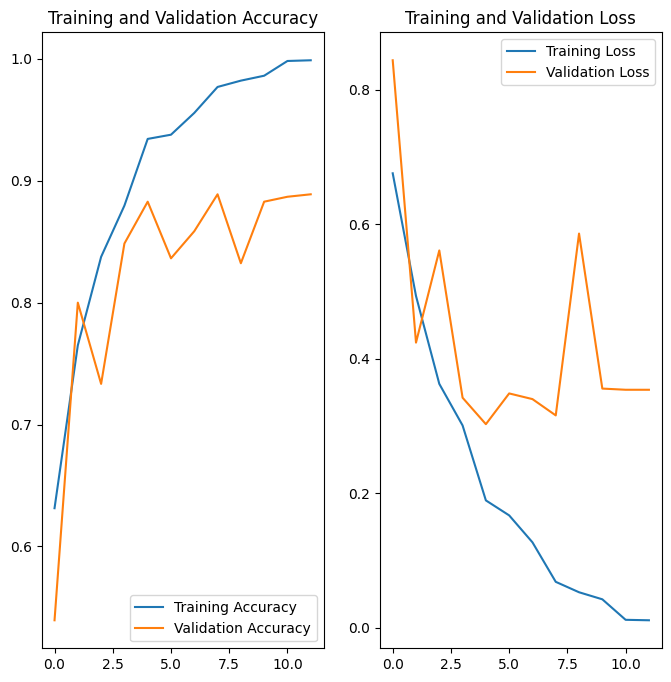

In [ ]:
num_epochs = len(history_base_model.history['loss'])
plot_metrics(history_base_model)

In [ ]:
min_loss_index = history_base_model.history['val_loss'].index(min(history_base_model.history['val_loss']))
print("Training Accuracy: ",history_base_model.history['accuracy'][min_loss_index])
print("Validation Accuracy: ",history_base_model.history['val_accuracy'][min_loss_index])

Training Accuracy:  0.9343317747116089
Validation Accuracy:  0.8828282952308655


In [ ]:
test_ds_1 = data_generator(data_dir_test,img_height, img_width, batch_size)

Found 250 files belonging to 3 classes.


In [ ]:
test_loss_1, test_acc_1 = base_model.evaluate(test_ds_1, batch_size=batch_size, verbose=2)

8/8 - 2s - loss: 0.4493 - accuracy: 0.8680 - 2s/epoch - 204ms/step


## Model #2

In [ ]:
batch_size=32
img_height = 256
img_width = 256
num_epochs = 50

In [ ]:
dropout_model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

dropout_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

dropout_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 256, 256, 1)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 16)      160       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 128, 128, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 64)       

In [ ]:
history_dropout_model = train_model("dropout_model",dropout_model)

Found 1736 files belonging to 3 classes.
Found 495 files belonging to 3 classes.


*** Params used in Model Training ****
Batch Size:  32
Epoch Size:  50
Image size: 256 256
***********************
Epoch 1/50
54/55 [============================>.] - ETA: 0s - loss: 0.7175 - accuracy: 0.6181
Epoch 1: val_loss improved from inf to 0.61544, saving model to dropout_model_2023-11-3017_28_48.356467/model-00001-0.71658-0.61866-0.61544-0.62222.h5
55/55 [==============================] - 16s 197ms/step - loss: 0.7166 - accuracy: 0.6187 - val_loss: 0.6154 - val_accuracy: 0.6222 - lr: 0.0010
Epoch 2/50
54/55 [============================>.] - ETA: 0s - loss: 0.4783 - accuracy: 0.7668
Epoch 2: val_loss improved from 0.61544 to 0.41368, saving model to dropout_model_2023-11-3017_28_48.356467/model-00002-0.47758-0.76728-0.41368-0.82020.h5
55/55 [==============================] - 14s 245ms/step - loss: 0.4776 - accuracy: 0.7673 - val_loss: 0.4137 - val_accuracy: 0.8202 - lr: 0.0010
Epoch 3/50
54/55 [============================>.] - ETA: 0s - loss: 0.3466 - accuracy: 0.8600
Epoch 3

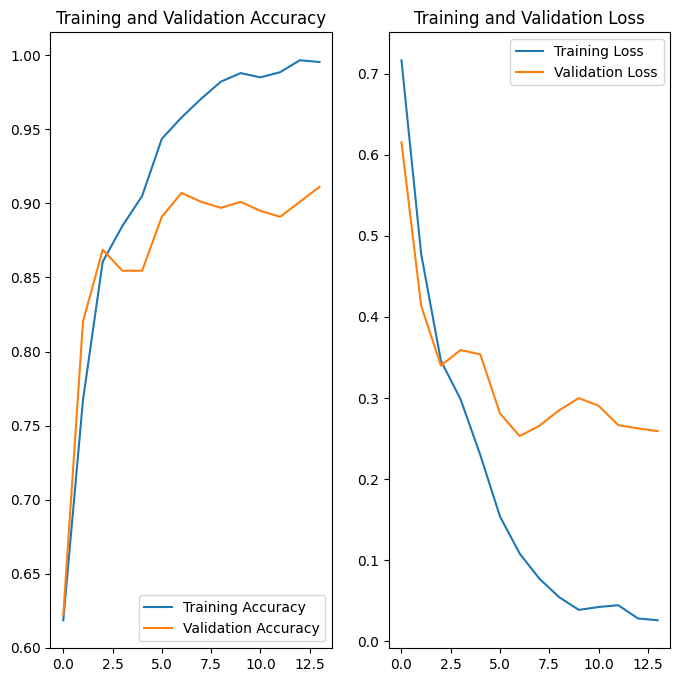

In [ ]:
num_epochs = len(history_dropout_model.history['loss'])
plot_metrics(history_dropout_model)

In [ ]:
min_loss_index = history_dropout_model.history['val_loss'].index(min(history_dropout_model.history['val_loss']))
print("Training Accuracy: ",history_dropout_model.history['accuracy'][min_loss_index])
print("Validation Accuracy: ",history_dropout_model.history['val_accuracy'][min_loss_index])

Training Accuracy:  0.9579492807388306
Validation Accuracy:  0.9070706963539124


In [ ]:
test_ds_2 = data_generator(data_dir_test,img_height, img_width, batch_size)

Found 250 files belonging to 3 classes.


In [ ]:
test_loss_2, test_acc_2 = dropout_model.evaluate(test_ds_2, batch_size=batch_size, verbose=2)

8/8 - 1s - loss: 0.3320 - accuracy: 0.8840 - 1s/epoch - 140ms/step


## Model #3

In [ ]:
batch_size=32
img_height = 256
img_width = 256
num_epochs = 50

In [ ]:
batch_norm_model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

batch_norm_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

batch_norm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 256, 256, 1)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 256, 256, 16)      160       
                                                                 
 batch_normalization (Batch  (None, 256, 256, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 128, 128, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 batch_normalization_1 (Bat  (None, 128, 128, 32)     

In [ ]:
history_batch_norm_model = train_model("batch_norm_model",batch_norm_model)

Found 1736 files belonging to 3 classes.
Found 495 files belonging to 3 classes.


*** Params used in Model Training ****
Batch Size:  32
Epoch Size:  50
Image size: 256 256
***********************
Epoch 1/50
54/55 [============================>.] - ETA: 0s - loss: 8.7191 - accuracy: 0.7378
Epoch 1: val_loss improved from inf to 75.24710, saving model to batch_norm_model_2023-11-3017_32_40.689431/model-00001-8.69800-0.73790-75.24710-0.00000.h5
55/55 [==============================] - 16s 228ms/step - loss: 8.6980 - accuracy: 0.7379 - val_loss: 75.2471 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/50
54/55 [============================>.] - ETA: 0s - loss: 2.4604 - accuracy: 0.8628
Epoch 2: val_loss did not improve from 75.24710
55/55 [==============================] - 13s 216ms/step - loss: 2.4496 - accuracy: 0.8629 - val_loss: 145.3060 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/50
54/55 [============================>.] - ETA: 0s - loss: 1.1822 - accuracy: 0.9086
Epoch 3: val_loss did not improve from 75.24710
55/55 [==============================] - 13s 216ms

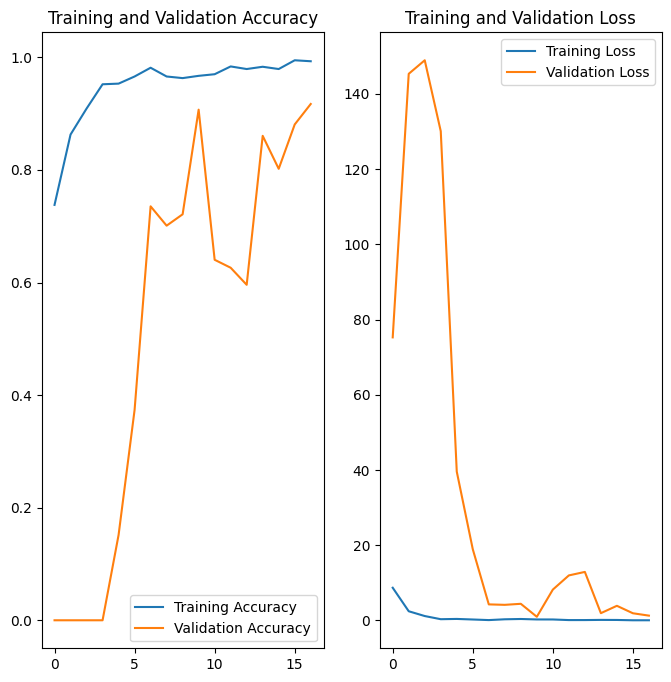

In [ ]:
num_epochs = len(history_batch_norm_model.history['loss'])
plot_metrics(history_batch_norm_model)

In [ ]:
min_loss_index = history_batch_norm_model.history['val_loss'].index(min(history_batch_norm_model.history['val_loss']))
print("Training Accuracy: ",history_batch_norm_model.history['accuracy'][min_loss_index])
print("Validation Accuracy: ",history_batch_norm_model.history['val_accuracy'][min_loss_index])

Training Accuracy:  0.9671658873558044
Validation Accuracy:  0.9070706963539124


In [ ]:
test_ds_3 = data_generator(data_dir_test,img_height, img_width, batch_size)

Found 250 files belonging to 3 classes.


In [ ]:
test_loss_3, test_acc_3 = batch_norm_model.evaluate(test_ds_3, batch_size=batch_size, verbose=2)

8/8 - 1s - loss: 1.3313 - accuracy: 0.9320 - 1s/epoch - 155ms/step


## Model #4

In [ ]:
batch_size=64
img_height = 256
img_width = 256
num_epochs = 50

In [ ]:
history_large_batch_model = train_model("large_batch_model",batch_norm_model)

Found 1736 files belonging to 3 classes.
Found 495 files belonging to 3 classes.


*** Params used in Model Training ****
Batch Size:  64
Epoch Size:  50
Image size: 256 256
***********************
Epoch 1/50
27/28 [===========================>..] - ETA: 0s - loss: 0.0418 - accuracy: 0.9948
Epoch 1: val_loss improved from inf to 1.20856, saving model to large_batch_model_2023-11-3017_37_32.563963/model-00001-0.04166-0.99482-1.20856-0.92323.h5
28/28 [==============================] - 16s 428ms/step - loss: 0.0417 - accuracy: 0.9948 - val_loss: 1.2086 - val_accuracy: 0.9232 - lr: 1.0000e-05
Epoch 2/50
27/28 [===========================>..] - ETA: 0s - loss: 0.0322 - accuracy: 0.9959
Epoch 2: val_loss improved from 1.20856 to 1.17582, saving model to large_batch_model_2023-11-3017_37_32.563963/model-00002-0.03208-0.99597-1.17582-0.92727.h5
28/28 [==============================] - 13s 399ms/step - loss: 0.0321 - accuracy: 0.9960 - val_loss: 1.1758 - val_accuracy: 0.9273 - lr: 1.0000e-05
Epoch 3/50
27/28 [===========================>..] - ETA: 0s - loss: 0.0401 - accuracy

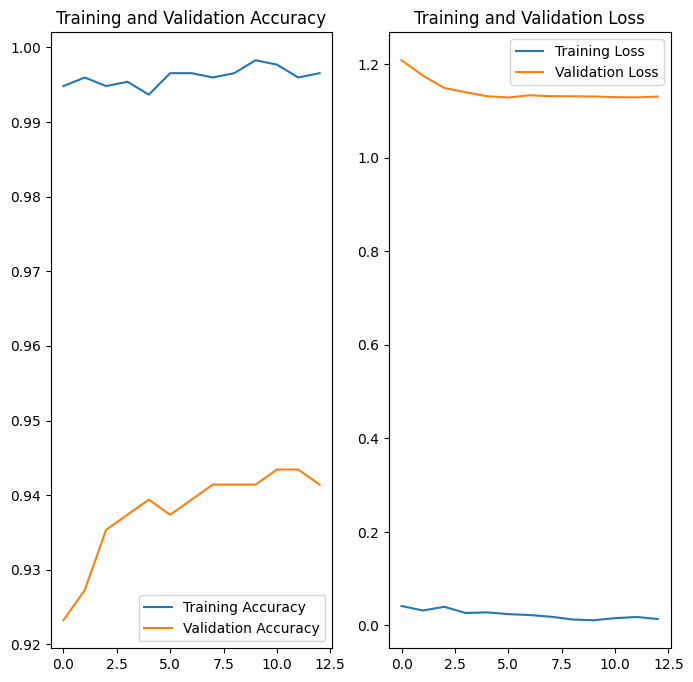

In [ ]:
num_epochs = len(history_large_batch_model.history['loss'])
plot_metrics(history_large_batch_model)

In [ ]:
min_loss_index = history_large_batch_model.history['val_loss'].index(min(history_large_batch_model.history['val_loss']))
print("Training Accuracy: ",history_large_batch_model.history['accuracy'][min_loss_index])
print("Validation Accuracy: ",history_large_batch_model.history['val_accuracy'][min_loss_index])

Training Accuracy:  0.9965437650680542
Validation Accuracy:  0.9373737573623657


## Test

In [ ]:
test_ds_4 = data_generator(data_dir_test,img_height, img_width, batch_size)

Found 250 files belonging to 3 classes.


In [ ]:
test_loss_4, test_acc_4 = batch_norm_model.evaluate(test_ds_4, batch_size=batch_size, verbose=2)

4/4 - 2s - loss: 1.2251 - accuracy: 0.9280 - 2s/epoch - 557ms/step
